# Application: Google PageRank

PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results.
It works by counting the number and the quality of links to a page. 

The PageRanks for an example network are shown below. Page C has a higher PageRank than Page E,
even though there are fewer links to C; the one link to C comes from an important page and hence
is of high value. 

![PageRanks-Example.png](pageranks-example.png "PageRank example")

(from <https://en.wikipedia.org/wiki/PageRank>)

## Algorithm

The starting point is the *webgraph*, which is a graph where each web page is a vertex, and a link
from one to another is an edge. The goal is to determine weights $PR(p_j)$ for each vertex (web page)
$p_j$ (*not* for the edges, as in a weighted graph), which can be interpreted as a probability that someone clicking links at random will eventually reach the page. This can be used to derive the simple relationship
between these probabilities shown below. Here it is also assumed that the person with probability $1-d$ stops clicking links and chooses a random page, where $d$ is a *damping factor*.

$$
PR(p_i) = \frac{1-d}{N} + d \sum_{p_j \in M(p_i)} \frac{PR(p_j)}{L(p_j)}
$$

$N$ is the total number of web pages, $M(p_i)$ is the set of pages that link *to* page $p_i$,
and $L(p_j)$ is the number of outbound links from page $p_j$.

## Iterative computation

We can solve the equation for the PageRanks iteratively, by first writing it
in matrix-vector form. Define the (column) vector of all PageRanks
$\boldsymbol{R} =\left[ PR(p_1), \ldots, PR(p_N)\right]$. Then the equation
can be written

$$
\boldsymbol{R} = d M \boldsymbol{R} + \frac{1-d}{N}\boldsymbol{1} = \mathrm{rhs}(\boldsymbol{R}\,)
$$

where $\boldsymbol{1}$ is a vector of all 1's, and $M=(K^{-1}A)^T$ where
$A$ is the regular adjancency matrix and $K$ is a diagonal matrix with the
outdegrees on the diagonal. A page with no outbound links (such as page
A in the example above) is a special case, which can be handled by adding
links to all other pages.

To solve this equation, we use fixpoint iteration:

$$
\boldsymbol{R}^{\ n+1} = \mathrm{rhs}(\boldsymbol{R}^{\ n})
$$

until the difference between two iterations is smaller than a tolerance.
For initial guess, we can use $\boldsymbol{R}^{\ 0} = \boldsymbol{1} / N$.

## Example

As an example, we reproduce the PageRanks for the graph shown above. First we create
the adjancency matrix $A$, including the added links for pages without outbound links:

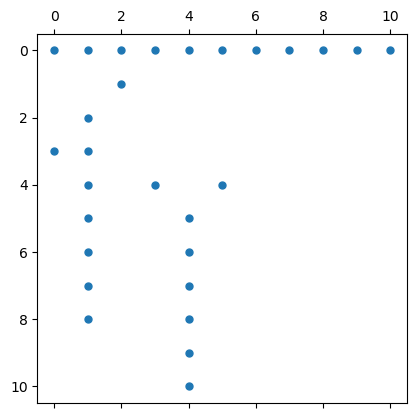

In [1]:
using PyPlot, SparseArrays
rows = [2,3,4,4,5,5,5,6,6,7,7,8,8,9,9,10,11]
cols = [3,2,1,2,2,4,6,2,5,2,5,2,5,2,5,5,5]
A = sparse(rows, cols, 1, 11, 11)
A[sum(A,dims=2)[:] .== 0,:] .= 1  # If a vertex has no outbound edges, all edges to all other vertices
spy(A, marker=".");

Next we implement a function for the algorithm. Note that $K^{-1}A$ is easiest evaluated by dividing the rows of $A$ by the vector of outward links $L$.

In [2]:
function pagerank(A, d=0.85, tol=1e-6)
    N = size(A,2)
    L = sum(A, dims=2)
    M = (A ./ L)'
    R = ones(N) / N
    while true
        newR = d * (M * R) .+ (1 - d) / N
        if maximum(abs.(newR - R)) < tol
            return newR
        end
        R = newR
    end
end

pagerank (generic function with 3 methods)

Finally we can compute the PageRanks of the example network:

In [3]:
R = pagerank(A, 0.85)
round.(100R, digits=1) # Show percentages

11-element Vector{Float64}:
  3.3
 38.4
 34.3
  3.9
  8.1
  3.9
  1.6
  1.6
  1.6
  1.6
  1.6